In [148]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

import sklearn as sk
from sklearn.preprocessing import MinMaxScaler

import statsmodels
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

import kaleido

In [100]:
df = pd.read_csv('../dados/trabalhados/gastos_serie_temporal.csv',parse_dates=['DATA'], index_col=0)
df.rename(columns={'VALOR_REEMBOLSADO': 'VALOR'}, inplace=True)
df.set_index(['DATA'], inplace=True)
df = df.loc[df.index < '2022-04-01']
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4108 entries, 2011-01-01 to 2022-03-31
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   VALOR   4108 non-null   float64
dtypes: float64(1)
memory usage: 64.2 KB


In [101]:
fig = px.scatter(df, x=df.index, y='VALOR', opacity=0.6, trendline='ols')
fig.show()

## Média dos últimos 3 meses

In [102]:
media_3_meses = df.rolling('30D').mean()

In [103]:
fig = px.scatter(media_3_meses, x=df.index, y='VALOR', opacity=0.6, trendline='ols')
fig.show()

In [104]:
fig = go.Figure([
    go.Scatter(x = df.index, y=df['VALOR'], mode='lines', name='Série temporal'),
    go.Scatter(x = media_3_meses.index, y = media_3_meses['VALOR'], mode='lines', name='Média móvel de 3 meses')
])

fig.show()

In [105]:
fig = px.histogram(df, x='VALOR', )
fig.show()

In [106]:
# Criar um append no array de 'VALOR'. Ese novo valor é a média dos últimos 3 meses

dias_anterioes = 90
dias_previsto = 30

prev_3meses = df.copy()

#prev_3meses.iloc[-1, 0] = prev_3meses.iloc[-91, 0].mean()
for i in range(dias_anterioes):
    prev_3meses.iloc[(-dias_anterioes-1+i), 0] = prev_3meses.iloc[(-dias_anterioes-1+i-dias_anterioes), 0].mean()
prev_3meses

fig = go.Figure([
    go.Scatter(x = df.iloc[(-dias_anterioes-1):].index, y=df.iloc[(-dias_anterioes-1):]['VALOR'], mode='lines', name='Série temporal'),
    go.Scatter(x = prev_3meses.iloc[(-dias_anterioes-1):].index, y = prev_3meses.iloc[(-dias_anterioes-1):]['VALOR'], mode='lines', name='Previsão baseada na média dos últimos 90 dias')
])

fig.show()

# Isso teria que ser feito em um loop. Por exemplo, para criar a previsão proo próximo mês:
# for i in range(30):
#   df['VALOR].append(df['VALOR']((-90+i):))

# Modelo ARIMA

In [107]:
adfuller(df['VALOR'])

(-6.743255177031651,
 3.080445367924359e-09,
 30,
 4077,
 {'1%': -3.4319549600249886,
  '5%': -2.8622491834480193,
  '10%': -2.567147505270297},
 98278.23914506283)

Pelo resultado do teste ADF é possível concluir que a série é estacionária, indicando que ela já está pronta para ser usada em um modelo

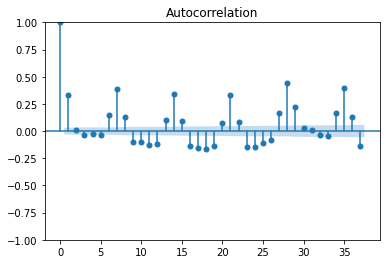

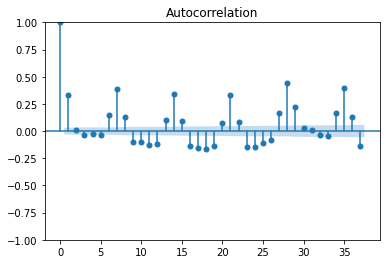

In [108]:
plot_acf(df['VALOR'])


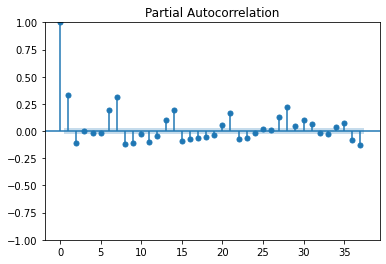

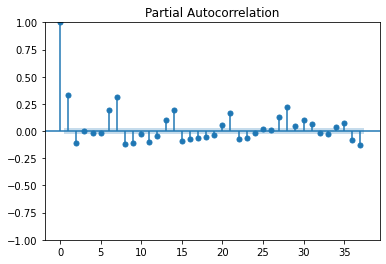

In [109]:
plot_pacf(df['VALOR'], method='ywm')

Utilizando esses gráficos não cheguei num bom resultado.
A próxima metodologia utiliza foi sugerida nesse vídeo, utilizando a biblioteca `pmdarima`: https://www.youtube.com/watch?v=8FCDpFhd1zk


In [110]:
from pmdarima import auto_arima

In [111]:
stepwise_fit = auto_arima(df, trace=True, suppress_warnings=True)
stepwise_fit.summary()

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=100486.926, Time=4.88 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=102236.654, Time=0.09 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=101950.884, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=101015.213, Time=0.75 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=102234.655, Time=0.06 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=100521.354, Time=1.24 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=100592.152, Time=1.03 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=100502.133, Time=2.57 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=100474.498, Time=2.76 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=100550.640, Time=1.84 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=6.27 sec
 ARIMA(2,1,4)(0,0,0)[0] intercept   : AIC=inf, Time=7.49 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=100542.351, Time=2.42 sec
 ARIMA(3,1,4)(0,0,0)[0] intercept   : AIC=inf, Time=7.54 sec
 ARIMA(2,1,3)(0,0,0)[0]   

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 4108
Model:               SARIMAX(2, 1, 3)   Log Likelihood              -50228.710
Date:                Wed, 08 Jun 2022   AIC                         100469.420
Time:                        11:08:04   BIC                         100507.343
Sample:                             0   HQIC                        100482.845
                               - 4108                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5477      0.045    -12.249      0.000      -0.635      -0.460
ar.L2         -0.5433      0.027    -19.782      0.000      -0.597      -0.489
ma.L1         -0.1292      0.043     -2.993      0.003      -0.214      -0.045
ma.L2         -0.1743      0.035     -4.930      0.000      -0.244      -0.105
ma.L3         -0.6626      0.027    -24.785      0.000      -0.715      -0.610
sigma2      2.723e+09   7.49e-12   3.64e+20      0.000    2.72e+09    2.72e+09
===================================================================================
Ljung-Box (L1) (Q):                  10.80   Jarque-Bera (JB):              7404.65
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.56   Skew:                             1.64
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.70
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 4.76e+35. Standard errors may be unstable.
"""

In [112]:
model = statsmodels.tsa.arima.model.ARIMA(df['VALOR'], order = (1, 0, 0))

model = model.fit()
model.summary()

d:\Sync\Profissional\Cursos\Alura_7DaysOfCode\ambiente-virtual\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

d:\Sync\Profissional\Cursos\Alura_7DaysOfCode\ambiente-virtual\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

d:\Sync\Profissional\Cursos\Alura_7DaysOfCode\ambiente-virtual\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  VALOR   No. Observations:                 4108
Model:                 ARIMA(1, 0, 0)   Log Likelihood              -50292.842
Date:                Wed, 08 Jun 2022   AIC                         100591.684
Time:                        11:08:05   BIC                         100610.646
Sample:                    01-01-2011   HQIC                        100598.397
                         - 03-31-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       6.545e+04   1184.327     55.265      0.000    6.31e+04    6.78e+04
ar.L1          0.3312      0.011     29.254      0.000       0.309       0.353
sigma2       2.52e+09      0.030   8.32e+10      0.000    2.52e+09    2.52e+09
===================================================================================
Ljung-Box (L1) (Q):                   5.64   Jarque-Bera (JB):              7321.64
Prob(Q):                              0.02   Prob(JB):                         0.00
Heteroskedasticity (H):               1.47   Skew:                             1.67
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.62
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 6.47e+24. Standard errors may be unstable.
"""

Como a base de dados tem 4168 registros, vou criar uma base de teste com 10% desse valor, o restante fica para treino

In [113]:
test_size=1000

df_train = df.iloc[:-test_size]
df_test = df.iloc[-test_size:]
print(df_train.shape, df_test.shape)
df_test

(3108, 1) (1000, 1)


,VALOR
DATA,
2019-07-06,15872.53
2019-07-07,5411.34
2019-07-08,93415.26
2019-07-09,60583.77
2019-07-10,96707.82
...,...
2022-03-27,18158.71
2022-03-28,50201.57
2022-03-29,120321.97


In [114]:
model = statsmodels.tsa.arima.model.ARIMA(df_train['VALOR'], order = (2, 1, 3), freq='D')
model = model.fit()
model.summary()

d:\Sync\Profissional\Cursos\Alura_7DaysOfCode\ambiente-virtual\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  VALOR   No. Observations:                 3108
Model:                 ARIMA(2, 1, 3)   Log Likelihood              -37918.298
Date:                Wed, 08 Jun 2022   AIC                          75848.596
Time:                        11:08:06   BIC                          75884.844
Sample:                    01-01-2011   HQIC                         75861.611
                         - 07-05-2019                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5543      0.050    -11.067      0.000      -0.652      -0.456
ar.L2         -0.5478      0.033    -16.429      0.000      -0.613      -0.482
ma.L1         -0.1168      0.047     -2.463      0.014      -0.210      -0.024
ma.L2         -0.1802      0.040     -4.500      0.000      -0.259      -0.102
ma.L3         -0.6681      0.031    -21.686      0.000      -0.729      -0.608
sigma2      2.585e+09   4.89e-12   5.28e+20      0.000    2.58e+09    2.58e+09
===================================================================================
Ljung-Box (L1) (Q):                   8.15   Jarque-Bera (JB):              3562.56
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.59   Skew:                             1.48
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.33
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 6.32e+36. Standard errors may be unstable.
"""

In [115]:
start = len(df_train)
end = len(df_train) + len(df_test) -1
pred = model.predict(start=start, end=end, typ='levels')
pred = pred.to_frame().rename(columns={'predicted_mean': 'VALOR'})
pred


,VALOR
2019-07-06,74277.701856
2019-07-07,68058.571720
2019-07-08,76303.190298
2019-07-09,75140.475706
2019-07-10,71268.401447
...,...
2022-03-27,73601.459057
2022-03-28,73601.459057
2022-03-29,73601.459057
2022-03-30,73601.459057


In [116]:
fig = px.line(pred, x=pred.index, y='VALOR')
fig.show()

In [117]:
fig = go.Figure([
    go.Scatter(x = df_test.index, y=df_test['VALOR'], mode='lines', name='Teste'),
    go.Scatter(x = pred.index, y = pred['VALOR'], mode='lines', name='Previsão')
])

fig.show()

In [118]:
# model = statsmodels.tsa.statespace.sarimax.SARIMAX(df_train['VALOR'], order = (2, 1, 3), seasonal_order=(1, 1, 1, 30), freq='D')
# model = model.fit()
# model.summary()

d:\Sync\Profissional\Cursos\Alura_7DaysOfCode\ambiente-virtual\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



KeyboardInterrupt: 

# Modelo LSTM

Baseado nesse vídeo: https://www.youtube.com/watch?v=S8tpSG6Q2H0

In [119]:
test_size=400

df_train = df.iloc[:-test_size]
df_test = df.iloc[-test_size:]
print(df_train.shape, df_test.shape)

(3708, 1) (400, 1)


É necessário transformar toda a série para uma escala de 0 a 1. Dessa forma o modelo tem melhor desempenho e não fica confuso se tiver uma mudança de escala entre os dados pra treino e os dados pra teste. (Acho que isso é mais importante no caso de séries não estacionárias, que não é tanto este caso)

In [120]:
scaler = MinMaxScaler()
scaler.fit(df_train)
scaled_train = scaler.transform(df_train)
scaled_test = scaler.transform(df_test)
scaled_train

array([[0.00971844],
       [0.00622896],
       [0.01496786],
       ...,
       [0.26399559],
       [0.30837089],
       [0.11606373]])

A partir dos dados transformados é necessário criar uma novas TimeSeries para o treinamento e previsão. A maneira como esse modelo funciona é que ele pega um quantidade n de números e prevê o n+1. Depois ele faz uma nova lista de n números, desprezando o primeiro e anexando no fim o número previsto, assim fazendo mais uma previsão.
`1, 2, 3 prevê=> 4 | 2, 3, 4 prevê=> 5 | 3, 4, 5 prevê=> 6 | e por aí vai...`

In [121]:
# Demonstração do gerador de TimeSeries

n_input = 5 # Tamanho do Array
n_features = 1 # Quantidade de TimeSeries
generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)

for i in range(3):
    X, y = generator[i]
    print(f"Batch nº{i}: O array {X.flatten()}\n previu o resultado {y}" )

Batch nº0: O array [0.00971844 0.00622896 0.01496786 0.01175442 0.06000499]
 previu o resultado [[0.04021539]]
Batch nº1: O array [0.00622896 0.01496786 0.01175442 0.06000499 0.04021539]
 previu o resultado [[0.03023515]]
Batch nº2: O array [0.01496786 0.01175442 0.06000499 0.04021539 0.03023515]
 previu o resultado [[0.01497299]]


In [122]:
# Gerando para 3 meses (90 dias)

n_input = 90 # Tamanho do Array
n_features = 1 # Quantidade de TimeSeries
generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)


In [123]:
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(n_input, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 100)               40800     
                                                                 
 dense_1 (Dense)             (None, 1)                 101       
                                                                 
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


In [135]:
model.fit(generator, epochs=40)

Epoch 1/40
3618/3618 [==============================] - 71s 20ms/step - loss: 0.0076
Epoch 2/40
3618/3618 [==============================] - 73s 20ms/step - loss: 0.0074
Epoch 3/40
3618/3618 [==============================] - 73s 20ms/step - loss: 0.0073
Epoch 4/40
3618/3618 [==============================] - 84s 23ms/step - loss: 0.0083
Epoch 5/40
3618/3618 [==============================] - 84s 23ms/step - loss: 0.0082
Epoch 6/40
3618/3618 [==============================] - 78s 21ms/step - loss: 0.0075
Epoch 7/40
3618/3618 [==============================] - 77s 21ms/step - loss: 0.0072
Epoch 8/40
3618/3618 [==============================] - 79s 22ms/step - loss: 0.0077
Epoch 9/40
3618/3618 [==============================] - 78s 22ms/step - loss: 0.0077
Epoch 10/40
3618/3618 [==============================] - 78s 21ms/step - loss: 0.0071
Epoch 11/40
3618/3618 [==============================] - 78s 22ms/step - loss: 0.0071
Epoch 12/40
3618/3618 [==============================] - 81s 22

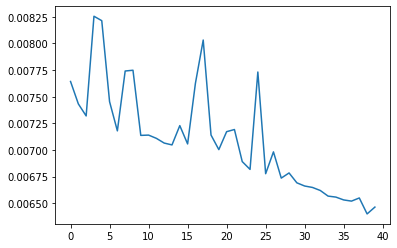

In [136]:
loss = model.history.history['loss']
plt.plot(range(len(loss)), loss)

In [152]:
model.save('../models/LSTM-20-epochs')

INFO:tensorflow:Assets written to: ../models/LSTM-20-epochs\assets


In [137]:
last_train_batch = scaled_train[-n_input:] # Os últimos noventa dias do conjunto de treino que vai servir para prever o primeiro dia do conjunto de teste
last_train_batch = last_train_batch.reshape((1, n_input, n_features)) # Formatação pra ficar igual o modelo OBS: Estudar melhor isso

In [138]:
# Prevendo o primeiro dia do conjunto de teste

model.predict(last_train_batch)

1/1 [==============================] - 0s 20ms/step


array([[0.17631134]], dtype=float32)

In [139]:
# O valore real do primeiro dia de teste
scaled_test[0]

array([0.1409317])

In [140]:
all_predictions = []
initial_batch = last_train_batch

for i in range(len(df_test)):
    pred = model.predict(initial_batch)[0]
    all_predictions.append(pred)
    initial_batch = np.append(initial_batch[:, 1:, :], [[pred]], axis=1)



1/1 [==============================] - 0s 20ms/step


In [141]:
all_predictions

[array([0.17631134], dtype=float32),
 array([0.16406928], dtype=float32),
 array([0.04970064], dtype=float32),
 array([0.04229089], dtype=float32),
 array([0.25179705], dtype=float32),
 array([0.21172889], dtype=float32),
 array([0.22733545], dtype=float32),
 array([0.22619735], dtype=float32),
 array([0.19173163], dtype=float32),
 array([0.0552921], dtype=float32),
 array([0.03832452], dtype=float32),
 array([0.23959516], dtype=float32),
 array([0.18936308], dtype=float32),
 array([0.19948784], dtype=float32),
 array([0.20060578], dtype=float32),
 array([0.16886301], dtype=float32),
 array([0.04801536], dtype=float32),
 array([0.02837807], dtype=float32),
 array([0.21888357], dtype=float32),
 array([0.17962147], dtype=float32),
 array([0.20002277], dtype=float32),
 array([0.20877862], dtype=float32),
 array([0.18330579], dtype=float32),
 array([0.05815395], dtype=float32),
 array([0.04393921], dtype=float32),
 array([0.25472316], dtype=float32),
 array([0.20570938], dtype=float32),
 a

In [142]:
all_predictions = scaler.inverse_transform(all_predictions)
all_predictions

array([[ 80250.0559286 ],
       [ 74696.809932  ],
       [ 22816.89835725],
       [ 19455.68632748],
       [114491.88807257],
       [ 96316.16410123],
       [103395.61639187],
       [102879.34866232],
       [ 87245.00813561],
       [ 25353.29500589],
       [ 17656.46182468],
       [108956.86559613],
       [ 86170.58426612],
       [ 90763.37774832],
       [ 91270.49992046],
       [ 76871.34364153],
       [ 22052.42134878],
       [ 13144.55295676],
       [ 99561.67435262],
       [ 81751.59693145],
       [ 91006.03581584],
       [ 94977.86420065],
       [ 83422.87488335],
       [ 26651.49099509],
       [ 20203.39648071],
       [115819.23087887],
       [ 93585.59672406],
       [100387.68784908],
       [100097.94334187],
       [ 83857.85327559],
       [ 24615.61421024],
       [ 15901.37494454],
       [110013.32956464],
       [ 88245.32798008],
       [ 96800.95299793],
       [ 99529.69531929],
       [ 86283.97430714],
       [ 26612.38241507],
       [ 186

In [150]:
df_test.loc[:,'Prediction'] = all_predictions
fig = go.Figure([
    go.Scatter(x = df_test.index, y=df_test['VALOR'], mode='lines', name='Teste'),
    go.Scatter(x = df_test.index, y=df_test['Prediction'], mode='lines', name='Previsão')
])

fig.update_layout(title_text='Previsão x Teste | LSTM com 40 epochs')

fig.write_image('..\plots\prev_x_text_LSTM.jpg', format='jpeg')
fig.show()

C:\Users\Bruno\AppData\Local\Temp\ipykernel_12424\1596609317.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



ValueError: 
Image export using the "kaleido" engine requires the kaleido package,
which can be installed using pip:
    $ pip install -U kaleido
